# Gesture recognition networks

### Imports

In [1]:
import os
import shutil

import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import torch.nn.functional as F

from tqdm import tqdm
from torchvision import datasets, transforms, models
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

import numpy as np
import matplotlib.pyplot as plt

### Configuration

In [2]:

class CONFIG:
    model_path = 'BestModel3.pt'
    num_epochs = 100
    lr = 1e-4
    batch_size = 16
    img_size = 224
    dataset = "division_5" # division_5 / division_4 depends on dataset
    rgb_depth = "RGB" # RGB / Depth depends on dataset
    classes1 = ['LeftProfile', 'LightOn', 'OcclusionPaper', 'RightProfile'] 
    classes2 = ['Neutral', 'OcclusionEyes', 'OcclusionMouth', 'OpenMouth', 'Smile']  


### Creating sorted classes for dataset



In [3]:
cfg = CONFIG()
data_dir = r"./EURECOM_Kinect_Face_Dataset"
destination_dir = r"./HeadDataset"
os.makedirs(destination_dir, exist_ok=True)

for folder in os.listdir(data_dir):
    folder_path = os.path.join(data_dir, folder)
    
    if os.path.isdir(folder_path):
        print(f"Processing folder: {folder}")
        
        # Loop through each class subfolder #
        for class_folder in os.listdir(folder_path):
            class_folder_path = os.path.join(folder_path, class_folder)
            
            if os.path.isdir(class_folder_path) and class_folder == "s2":
                print(f"  Class folder: {class_folder}")
                
                for class_Sfolder in os.listdir(class_folder_path):
                    class_Subfolder_path = os.path.join(class_folder_path, class_Sfolder)
                    
                    if os.path.isdir(class_Subfolder_path) and class_Sfolder == cfg.rgb_depth:
                        if class_Sfolder == "Depth":
                            class_Subfolder_path = os.path.join(class_Subfolder_path,"DepthBMP")
                        print(f"    Class Sub folder: {class_Sfolder}")

                        for filename in os.listdir(class_Subfolder_path):
                            file_path = os.path.join(class_Subfolder_path, filename)
                            if cfg.dataset == "division_4":
                                # Left Profile
                                if os.path.isfile(file_path) and "LeftProfile" in filename:
                                    print(f"        Moving file: {filename}")
                                    os.makedirs(destination_dir+r"/001", exist_ok=True)
                                    shutil.copy(file_path, os.path.join(destination_dir+r"/001", filename))
                                # Light on
                                if os.path.isfile(file_path) and "LightOn" in filename:
                                    print(f"        Moving file: {filename}")
                                    os.makedirs(destination_dir+r"/002", exist_ok=True)
                                    shutil.copy(file_path, os.path.join(destination_dir+r"/002", filename))
                                # RightProfile
                                if os.path.isfile(file_path) and "RightProfile" in filename:
                                    print(f"        Moving file: {filename}")
                                    os.makedirs(destination_dir+r"/008", exist_ok=True)
                                    shutil.copy(file_path, os.path.join(destination_dir+r"/008", filename))
                                # OcclusionPaper
                                if os.path.isfile(file_path) and "OcclusionPaper" in filename:
                                    print(f"        Moving file: {filename}")
                                    os.makedirs(destination_dir+r"/006", exist_ok=True)
                                    shutil.copy(file_path, os.path.join(destination_dir+r"/006", filename))
                            if cfg.dataset == "division_5":
                                # Neutral
                                if os.path.isfile(file_path) and "Neutral" in filename:
                                    print(f"        Moving file: {filename}")
                                    os.makedirs(destination_dir+r"/003", exist_ok=True)
                                    shutil.copy(file_path, os.path.join(destination_dir+r"/003", filename))
                                # OcclusionEyes
                                if os.path.isfile(file_path) and "OcclusionEyes" in filename:
                                    print(f"        Moving file: {filename}")
                                    os.makedirs(destination_dir+r"/004", exist_ok=True)
                                    shutil.copy(file_path, os.path.join(destination_dir+r"/004", filename))
                                # OcclusionMouth
                                if os.path.isfile(file_path) and "OcclusionMouth" in filename:
                                    print(f"        Moving file: {filename}")
                                    os.makedirs(destination_dir+r"/005", exist_ok=True)
                                    shutil.copy(file_path, os.path.join(destination_dir+r"/005", filename))
                                # OpenMouth
                                if os.path.isfile(file_path) and "OpenMouth" in filename:
                                    print(f"        Moving file: {filename}")
                                    os.makedirs(destination_dir+r"/007", exist_ok=True)
                                    shutil.copy(file_path, os.path.join(destination_dir+r"/007", filename))
                                # Smile
                                if os.path.isfile(file_path) and "Smile" in filename:
                                    print(f"        Moving file: {filename}")
                                    os.makedirs(destination_dir+r"/009", exist_ok=True)
                                    shutil.copy(file_path, os.path.join(destination_dir+r"/009", filename))

Processing folder: 0001
  Class folder: s2
    Class Sub folder: RGB
        Moving file: rgb_0001_s2_Neutral.bmp
        Moving file: rgb_0001_s2_OcclusionEyes.bmp
        Moving file: rgb_0001_s2_OcclusionMouth.bmp
        Moving file: rgb_0001_s2_OpenMouth.bmp
        Moving file: rgb_0001_s2_Smile.bmp
Processing folder: 0002
  Class folder: s2
    Class Sub folder: RGB
        Moving file: rgb_0002_s2_Neutral.bmp
        Moving file: rgb_0002_s2_OcclusionEyes.bmp
        Moving file: rgb_0002_s2_OcclusionMouth.bmp
        Moving file: rgb_0002_s2_OpenMouth.bmp
        Moving file: rgb_0002_s2_Smile.bmp
Processing folder: 0003
  Class folder: s2
    Class Sub folder: RGB
        Moving file: rgb_0003_s2_Neutral.bmp
        Moving file: rgb_0003_s2_OcclusionEyes.bmp
        Moving file: rgb_0003_s2_OcclusionMouth.bmp
        Moving file: rgb_0003_s2_OpenMouth.bmp
        Moving file: rgb_0003_s2_Smile.bmp
Processing folder: 0004
  Class folder: s2
    Class Sub folder: RGB
        Mo

### CNN structure

In [4]:

class CNN6Conv6FC(nn.Module):
    def __init__(self, num_classes, num_blocks):
        super(CNN6Conv6FC, self).__init__()
        self.num_classes = num_classes
        self.conv0 = nn.Conv2d(in_channels=1,  out_channels=64, kernel_size=3, stride=1, padding=1)

        preserve = []
        collapse = []
        for i in range(num_blocks):
            sq = nn.Sequential(
                     nn.Conv2d(in_channels=64, out_channels=64, kernel_size=5, stride=1, padding=2),
                     nn.BatchNorm2d(64),
                     nn.LeakyReLU(negative_slope=0.01, inplace=True))
            preserve.append(sq)
            collapse.append(
                nn.Sequential(
                    nn.Conv2d(in_channels=64, out_channels=64, kernel_size=5, stride=2, padding=1),
                    nn.MaxPool2d(kernel_size=5, stride=1, padding=0))
            )

            
        self.preserve = nn.ModuleList(preserve)
        self.collapse = nn.ModuleList(collapse)

        self.classifier = nn.Sequential(
            nn.LazyLinear(1024),
            nn.LeakyReLU(negative_slope=0.01, inplace=True),
            nn.Linear(1024, 512),
            nn.LeakyReLU(negative_slope=0.01, inplace=True),
            nn.Linear(512, 256),
            nn.LeakyReLU(negative_slope=0.01, inplace=True),
            nn.Linear(256, 128),
            nn.LeakyReLU(negative_slope=0.01, inplace=True),
            nn.Linear(128, 64),
            nn.LeakyReLU(negative_slope=0.01, inplace=True),
            nn.Linear(64, num_classes) 
        )
        
    def forward(self, x):
        x = self.conv0(x)

        for pr, cl in zip(self.preserve, self.collapse):
            x = pr(x) + x
            x = cl(x)

        x = x.view(x.size(0), -1) 
        x = self.classifier(x)
        
        return x


### Dataloader

In [5]:
cfg = CONFIG()
transform = transforms.Compose([
    transforms.Resize((cfg.img_size, cfg.img_size)),  
    transforms.ToTensor(),        
    transforms.Grayscale(), 
    transforms.Normalize((0.5), (0.5))  
])

augmented_transform = transforms.Compose([
    transforms.Resize((cfg.img_size, cfg.img_size)),  
    transforms.RandomRotation(30),  
    transforms.RandomHorizontalFlip(),  
    transforms.RandomVerticalFlip(),  
    transforms.RandomAffine(10),  
    transforms.ToTensor(),  
    transforms.Grayscale(),  
    transforms.GaussianBlur(9, sigma=(0.5, 10.0)),
    transforms.RandomResizedCrop(size=cfg.img_size, scale=(0.7, 1)),
    transforms.Normalize((0.5,), (0.5,))  
])


dataset = datasets.ImageFolder(root=r'./HeadDataset', transform=transform)
augmented_dataset = datasets.ImageFolder(root=r'./HeadDataset', transform=augmented_transform)

train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size

train_dataset, test_dataset =  data.random_split(dataset, [train_size, test_size])

combined_dataset = data.ConcatDataset([augmented_dataset, train_dataset])


trainloader =  data.DataLoader(combined_dataset, batch_size=cfg.batch_size, shuffle=True, num_workers=2)
testloader =  data.DataLoader(test_dataset, batch_size=cfg.batch_size, shuffle=False, num_workers=2)
num_classes = len(dataset.class_to_idx)
print(num_classes)

5


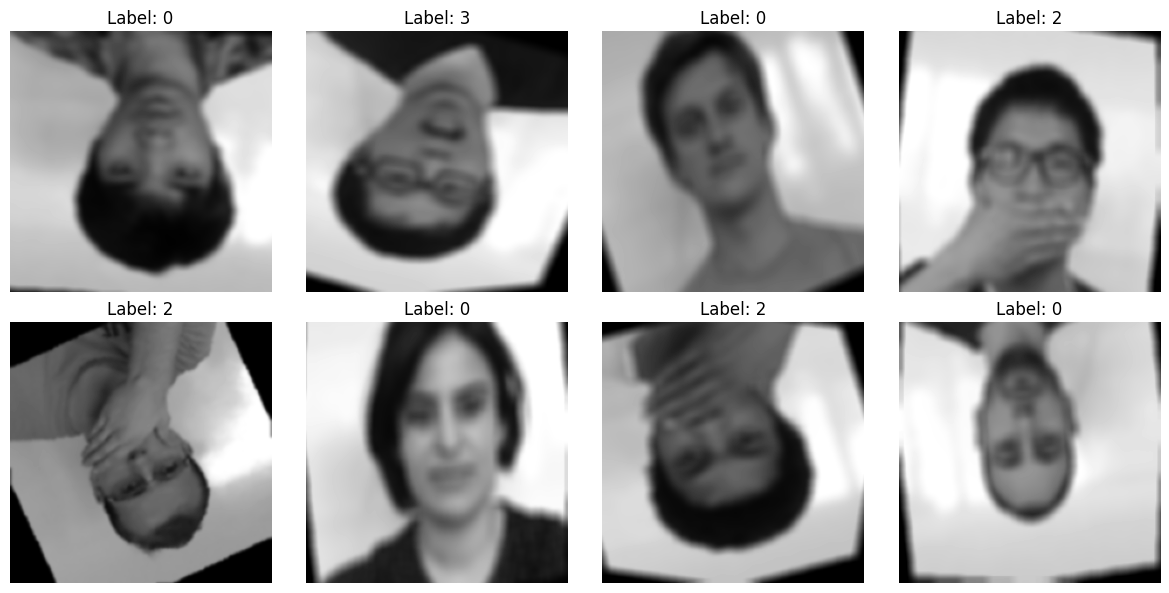

In [6]:
data_iter = iter(trainloader)
images, labels = next(data_iter)

random_indices = np.random.choice(images.size(0), 8, replace=False)
images = images[random_indices]
labels = labels[random_indices]

# Convert images to numpy and plot
fig, axes = plt.subplots(2, 4, figsize=(12, 6))

for i in range(8):
    ax = axes[i//4, i%4]
    image = images[i].squeeze(0).numpy() 
    ax.imshow(image, cmap='gray')  
    ax.axis('off')
    ax.set_title(f"Label: {labels[i].item()}")

plt.tight_layout()
plt.show()


### NET Setup and training

In [13]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

model = CNN6Conv6FC(num_classes=num_classes, num_blocks=4).to(device)
criterion = nn.CrossEntropyLoss()  # For classification tasks
optimizer = optim.AdamW(model.parameters(), lr=cfg.lr)  # Adam optimizer with learning rate

Using device: cuda


In [14]:
model

CNN6Conv6FC(
  (conv0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (preserve): ModuleList(
    (0-3): 4 x Sequential(
      (0): Conv2d(64, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.01, inplace=True)
    )
  )
  (collapse): ModuleList(
    (0-3): 4 x Sequential(
      (0): Conv2d(64, 64, kernel_size=(5, 5), stride=(2, 2), padding=(1, 1))
      (1): MaxPool2d(kernel_size=5, stride=1, padding=0, dilation=1, ceil_mode=False)
    )
  )
  (classifier): Sequential(
    (0): LazyLinear(in_features=0, out_features=1024, bias=True)
    (1): LeakyReLU(negative_slope=0.01, inplace=True)
    (2): Linear(in_features=1024, out_features=512, bias=True)
    (3): LeakyReLU(negative_slope=0.01, inplace=True)
    (4): Linear(in_features=512, out_features=256, bias=True)
    (5): LeakyReLU(negative_slope=0.01, inplace=True)
    (6): Linear(in

In [16]:
sum([p.numel() for p in model.parameters()])

3157893

In [17]:
best_accuracy = 0.0
all_labels = []
all_predictions = []
loss_timeline = []
acc_timeline = []
val_loss_timeline = []
val_acc_timeline = []

# Create a progress bar for the current epoch
progress_bar = tqdm(range(2*cfg.num_epochs))

for epoch in progress_bar:
    model.train()
    running_loss = 0.0
    correct_predictions = 0
    total_predictions = 0

    for i, (inputs, labels) in enumerate(trainloader):  
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()

        outputs = model(inputs)

        loss = criterion(outputs, labels)

        loss.backward()

        optimizer.step()

        running_loss += loss.item()
        
        _, predicted = torch.max(outputs.data, 1)
        
        correct_predictions += (predicted == labels).sum().item()
        total_predictions += labels.size(0)
        all_labels.extend(labels.cpu().numpy())
        all_predictions.extend(predicted.cpu().numpy())

        # Update progress bar with current loss and accuracy
        progress_bar.set_postfix({
            'loss': loss.item(),
            'accuracy': (correct_predictions / total_predictions) * 100
        })

    epoch_loss = running_loss / len(trainloader)
    epoch_accuracy = (correct_predictions / total_predictions) * 100
    loss_timeline.append(epoch_loss)
    acc_timeline.append(epoch_accuracy)

    # Validation loop
    model.eval()  
    val_running_loss = 0.0
    val_preds = []
    val_labels = []
    correct_predictions = 0
    total_predictions = 0
    with torch.no_grad():  
        for inputs, labels in testloader:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            val_running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            

            correct_predictions += (predicted == labels).sum().item()
            total_predictions += labels.size(0)
            val_preds.extend(predicted.cpu().numpy())
            val_labels.extend(labels.cpu().numpy())

    validation_accuracy = (correct_predictions / total_predictions) * 100
    val_loss_timeline.append(val_running_loss / len(testloader))
    val_acc_timeline.append(validation_accuracy)
    progress_bar.set_description(f"Epoch {epoch+1}/{cfg.num_epochs} - Loss: {epoch_loss:.4f} - Accuracy: {epoch_accuracy:.2f}% Validation Accuracy: {validation_accuracy:.2f}%")
    
    if validation_accuracy > best_accuracy:
        torch.save(model.state_dict(), cfg.model_path)
        
    # if epoch == cfg.num_epochs - 1:  
    conf_train_matrix = confusion_matrix(all_labels, all_predictions)
    conf_val_matrix = confusion_matrix(val_labels, val_preds)
print("Training finished.")

Epoch 200/100 - Loss: 0.0979 - Accuracy: 95.09% Validation Accuracy: 92.31%: 100%|██████████| 200/200 [17:21<00:00,  5.21s/it, loss=0.0326, accuracy=95.1]  

Training finished.


In [18]:
disp = ConfusionMatrixDisplay(confusion_matrix=conf_train_matrix, display_labels=['Neutral', 'OcclusionEyes', 'OcclusionMouth', 'OpenMouth', 'Smile']   )
disp2 = ConfusionMatrixDisplay(confusion_matrix=conf_val_matrix, display_labels=['Neutral', 'OcclusionEyes', 'OcclusionMouth', 'OpenMouth', 'Smile']   )

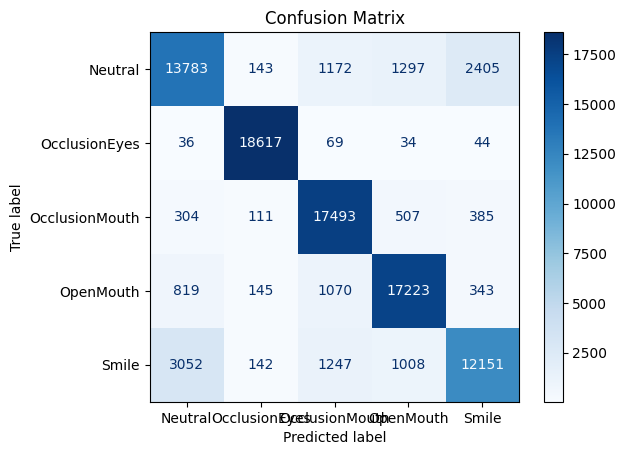

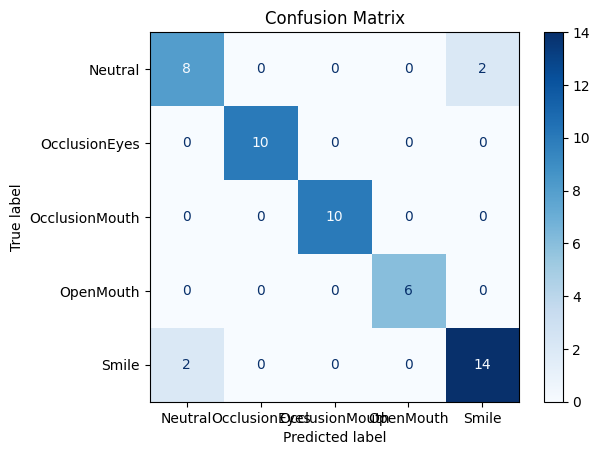

In [19]:
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

disp2.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

In [21]:
cfg.num_epochs = 2*cfg.num_epochs

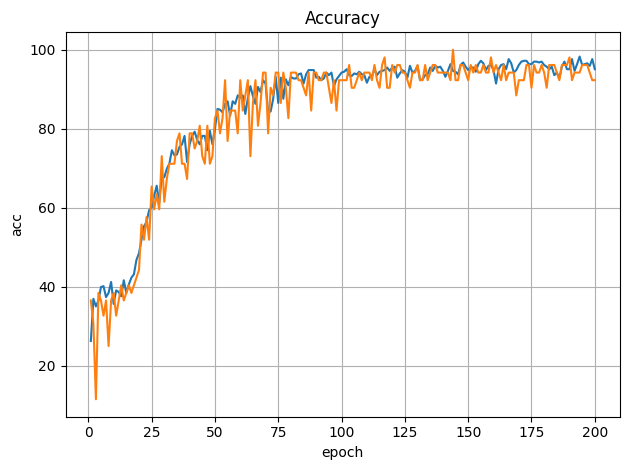

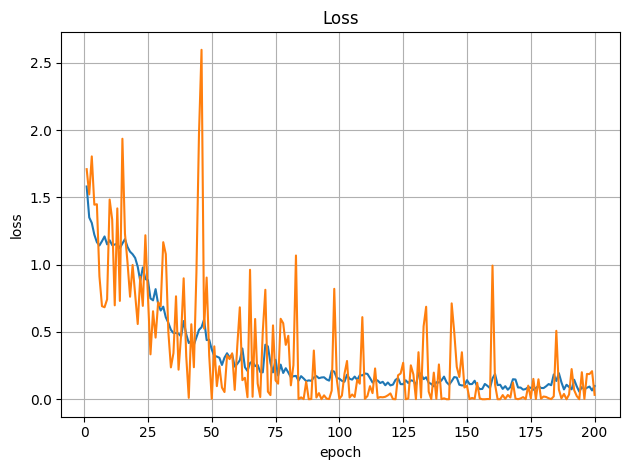

In [22]:
plt.plot(np.linspace(1, cfg.num_epochs, cfg.num_epochs),acc_timeline)
plt.plot(np.linspace(1, cfg.num_epochs, cfg.num_epochs),val_acc_timeline)
plt.title("Accuracy")
plt.ylabel("acc")
plt.xlabel("epoch")
plt.grid()
plt.tight_layout()
plt.show()

plt.plot(np.linspace(1, cfg.num_epochs, cfg.num_epochs),loss_timeline)
plt.plot(np.linspace(1, cfg.num_epochs, cfg.num_epochs),val_loss_timeline)
plt.title("Loss")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.grid()
plt.tight_layout()
plt.show()

In [23]:
torch.save(model.state_dict(), "model_2.pt")

In [39]:
from torchviz import make_dot

x = torch.zeros(1, 1, 224, 224, dtype=torch.float, requires_grad=False).to(device)
out = model(x)
make_dot(out, params=dict(list(model.named_parameters()))).render("rnn_torchviz", format="png")

'rnn_torchviz.png'